# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. 

Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [2]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

#Import of preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
from sentence_transformers import SentenceTransformer

import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [18]:
df_reviews = pd.read_csv("C:/Users/david/1.Archivos-Directorios/Python/Tripleten/Sprint 16/Datos/imdb_reviews.tsv", sep='\t', dtype={'votes': 'Int64'})
df_reviews.info()
print("Importación de datos completada. Hay un par de registros con valores nulos en average_rating y votes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [5]:
#Duplicados 
print(df_reviews.duplicated().sum(), "\nSin Duplicados")

#Remoción de nulos
df_reviews.dropna(inplace=True)
print("Registros con valores nulos removidos. 2 registros eliminados.")

display(df_reviews.describe())
print("Equilibrio de datos adecuado ambos cernaos a 50%, los negativos son ligeramente menos con un 49.89% de representación.")
print("\nCantidades de revies negativos y positivos:", df_reviews["pos"].value_counts(), "\nHay 101 revisiones positivas adicionales al número de negativos.")

0 
Sin Duplicados
Registros con valores nulos removidos. 2 registros eliminados.


,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,47329.0,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,25562.917323,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,83670.039163,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


Equilibrio de datos adecuado ambos cernaos a 50%, los negativos son ligeramente menos con un 49.89% de representación.

Cantidades de revies negativos y positivos: pos
0    23715
1    23614
Name: count, dtype: int64 
Hay 101 revisiones positivas adicionales al número de negativos.


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

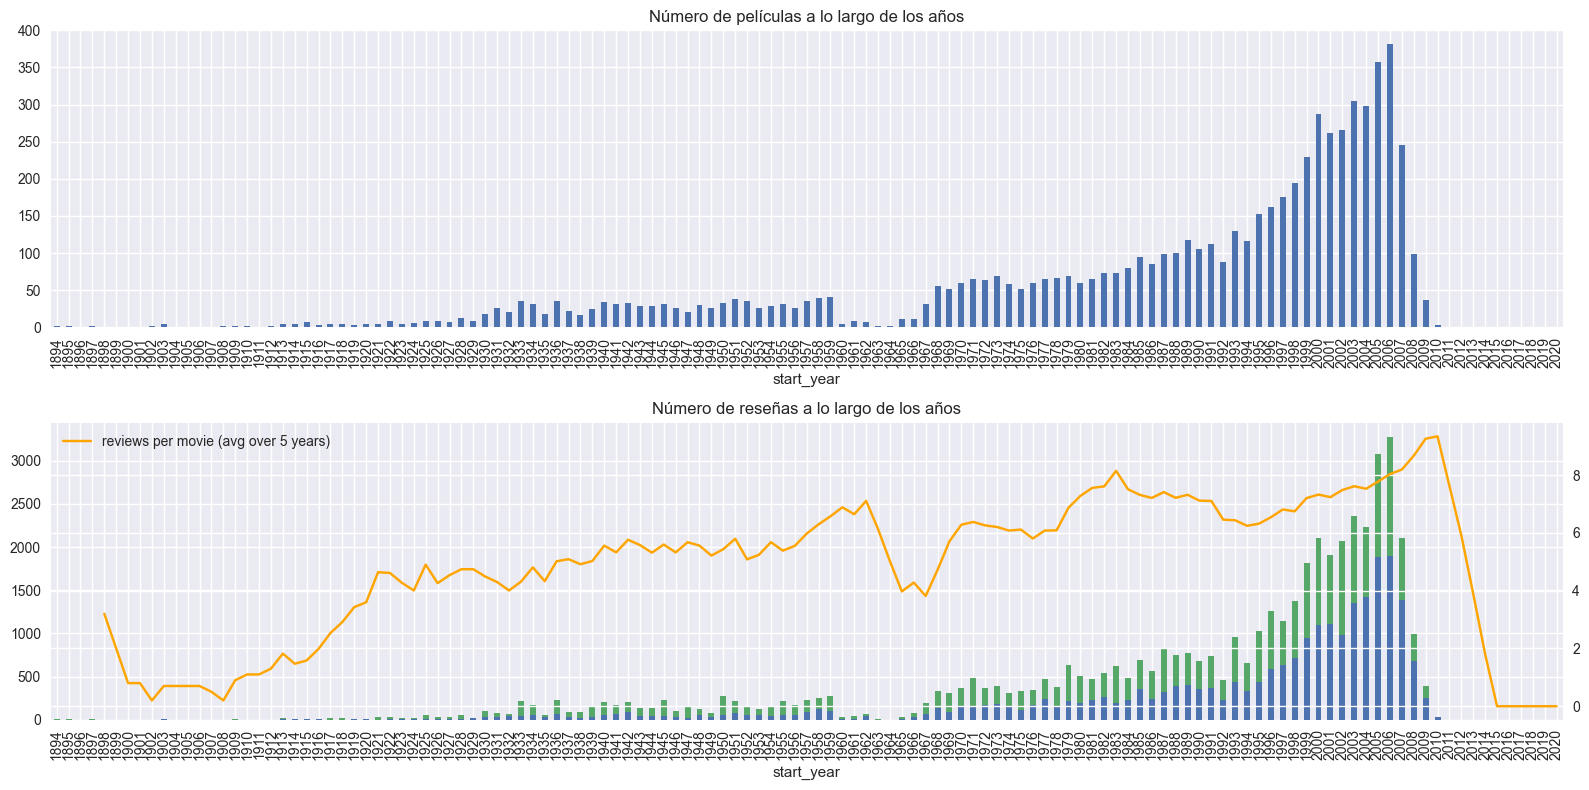

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

La mayoría de reseñas recibidas por película son de 1 a 5.


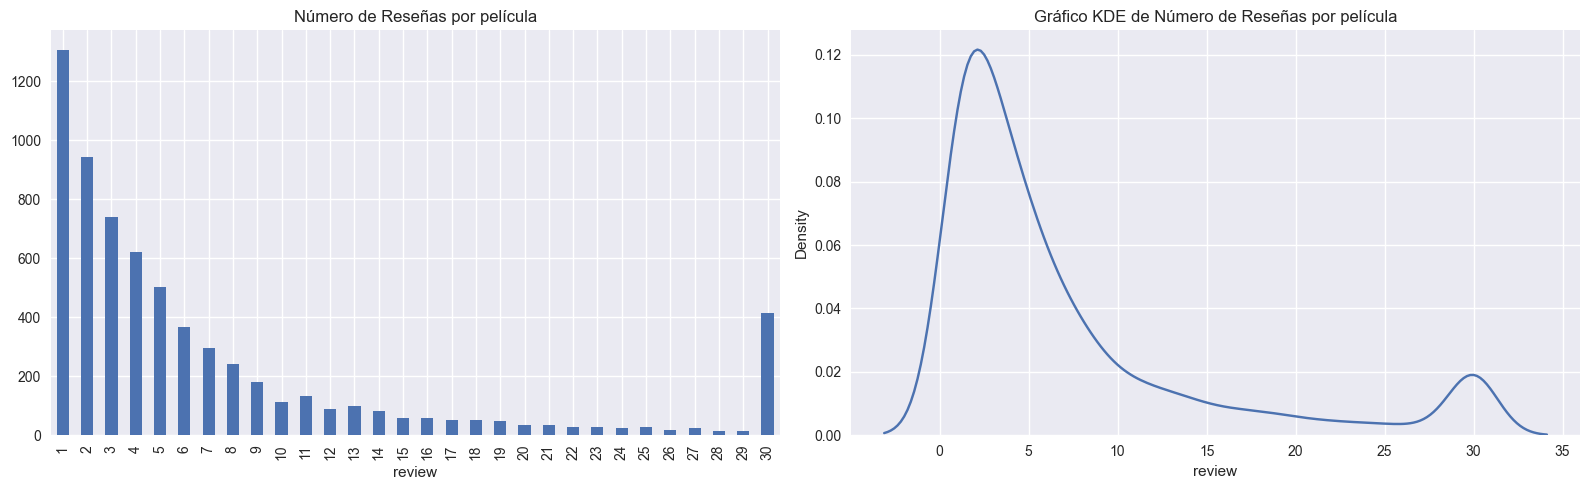

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Número de Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de Número de Reseñas por película')

fig.tight_layout()
print("La mayoría de reseñas recibidas por película son de 1 a 5.")

El patrón de puntuaciones está ampliamente conservado entre el set de datos de entrenamiento y de prueba.


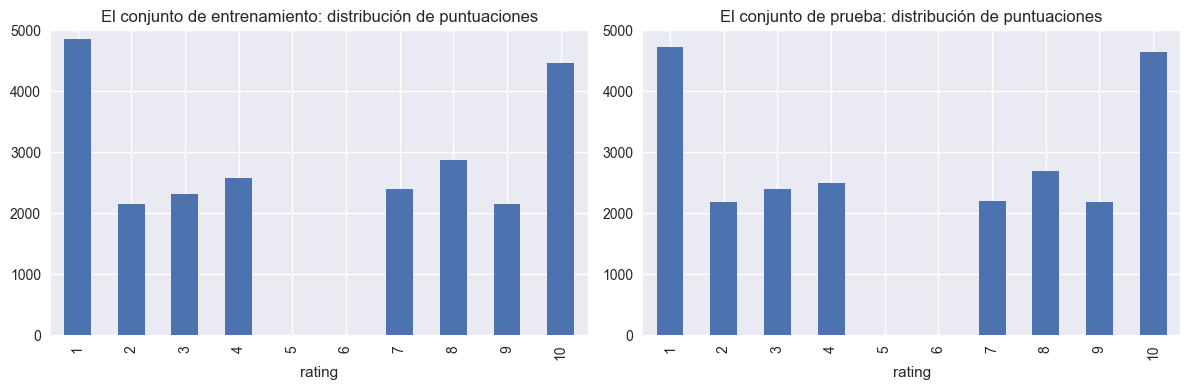

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()
print("El patrón de puntuaciones está ampliamente conservado entre el set de datos de entrenamiento y de prueba.")

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\david\AppData\Local\Temp\ipykernel_10772\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\david\AppData\Local\Temp\ipykernel_10772\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\david\AppData\Local\Temp\ipykernel_10772\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\david\AppData\Local\Temp\ipykernel_10772\1324160450.py:31: UserWarning: 

Support for a

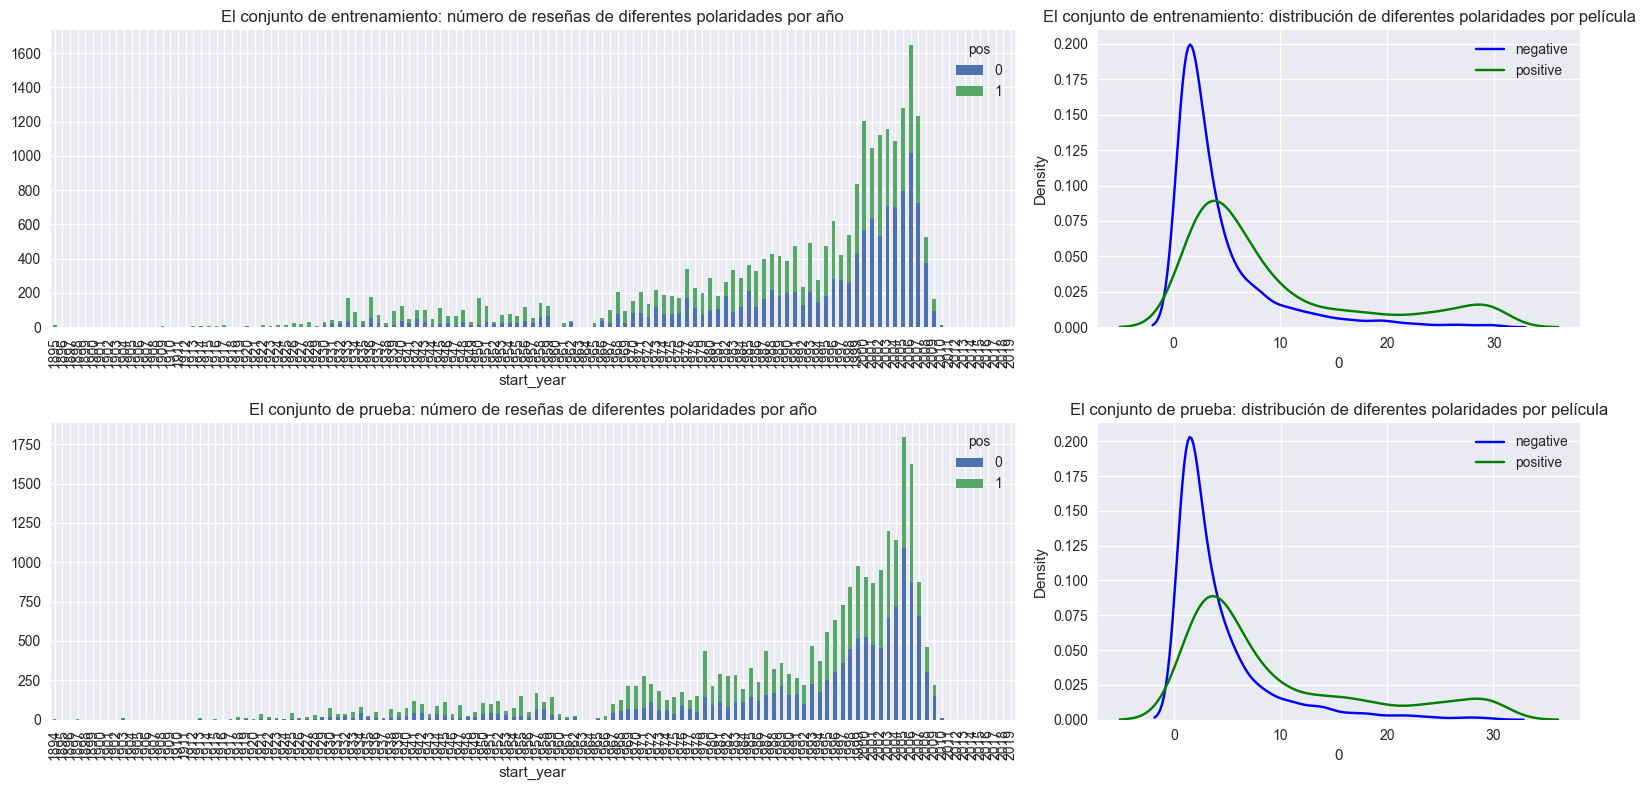

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
#Función de limpieza 
def clean_text(text):
    # Convierte a minúsculas
    text = text.lower()
    
    # Elimina todo lo que no sean letras ni apóstrofes
    text = re.sub(r"[^a-z\s']", ' ', text)
    
    # Elimina espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



df_reviews['review_norm'] = df_reviews["review"].apply(clean_text)
#Revisar el formato 
print(df_reviews["review_norm"].sample(3).values)
print("El formato se ve acorde en minúsculas y sin puntuaciones salvo que a veces se pueden encontrar algunos espacios extra.")

["a touching love story reminiscent of in the mood for love' drawing heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other the story focuses on a schoolteacher who wants so much to be a model teacher as well as a good husband and father a senior student is very attracted to him as the story unfolds we see the emotions below the surface in his year marriage and how he grapples with the moral dilemmas that face him a beautiful and moving story"
 "this is a top car flick its a work of art yer a work of art all classic cars no plastic fantastic i have watched it over over again i have worn out two video tapes and will wear out lots more lots more car lovers young or old will love this film watch it more than time so hire it or buy it just see it i wish they would make more car movies like this v power not gassed up little whipper snippers shes a right motor magic the heap the chariot you've got to learn to feel the power"
 "i rarely even bot

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [13]:
#Aplicar la lematización en una columna nueva. (opcional: Toma mucho tiempo y no dió resultados significativamente mejores)
#Computacionalmente exhaustivo. Toma muchos minutos. 12 minutos de manera local. 
#df_reviews["review_lemma"] = df_reviews["review_norm"].apply(text_preprocessing_3)

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train["review_norm"]
test_features = df_reviews_test["review_norm"]

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [15]:
#Vectorización TF-IDF
stop_words = stopwords.words("english")
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000, min_df=5)
X_train_vect = vectorizer.fit_transform(train_features)
X_test_vect = vectorizer.fit_transform(test_features)

In [16]:
#Muestreo para embeddings
train_embed_feat_sample, _ = train_test_split(train_features, train_size=0.10, random_state=54321)
test_embed_feat_sample, _ = train_test_split(test_features, train_size=0.10, random_state=54321)
train_embed_target_sample, _ = train_test_split(train_target, train_size=0.10, random_state=54321)
test_embed_target_sample, _ = train_test_split(test_target, train_size=0.10, random_state=54321)


In [ ]:
#Embeddings para modelo 4. 
#El modelo BERT tarda horas en entrenar con esta cantidad de datos por lo tanto se buscará usar un 5% de los datos. 

#Modelo para generar los embeddings
#embedding_model = SentenceTransformer('all-MiniLM-L12-v2') #Este modelo para generar embeddings está optimizado para velocidad de procesamiento más que para maximizar F1. 
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') 
train_embeddings = embedding_model.encode(train_embed_feat_sample.tolist(), batch_size=32, show_progress_bar=True)
test_embeddings = embedding_model.encode(test_embed_feat_sample.tolist(), batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
#Guardar en un archivo una muestra de las representaciones semánticas de los mensajes: 10%
np.savez_compressed('train_embeddings_scaled.npz', train = train_embeddings)
np.savez_compressed('test_embeddings_scaled.npz', test = test_embeddings)

## Trabajar con modelos

### Modelo 0 - Constante

In [ ]:
#Iniciar el modelo dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=54321)
#Entrenar 
dummy.fit(X_train_vect, train_target)

DummyClassifier(random_state=54321, strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
El modelo no identifica verdaderos positivos porque fue entrenado para mencionar lo más frecuente que en entrenamiento fueron los valores negativos.
pos
0    11912
1    11884
Name: count, dtype: int64


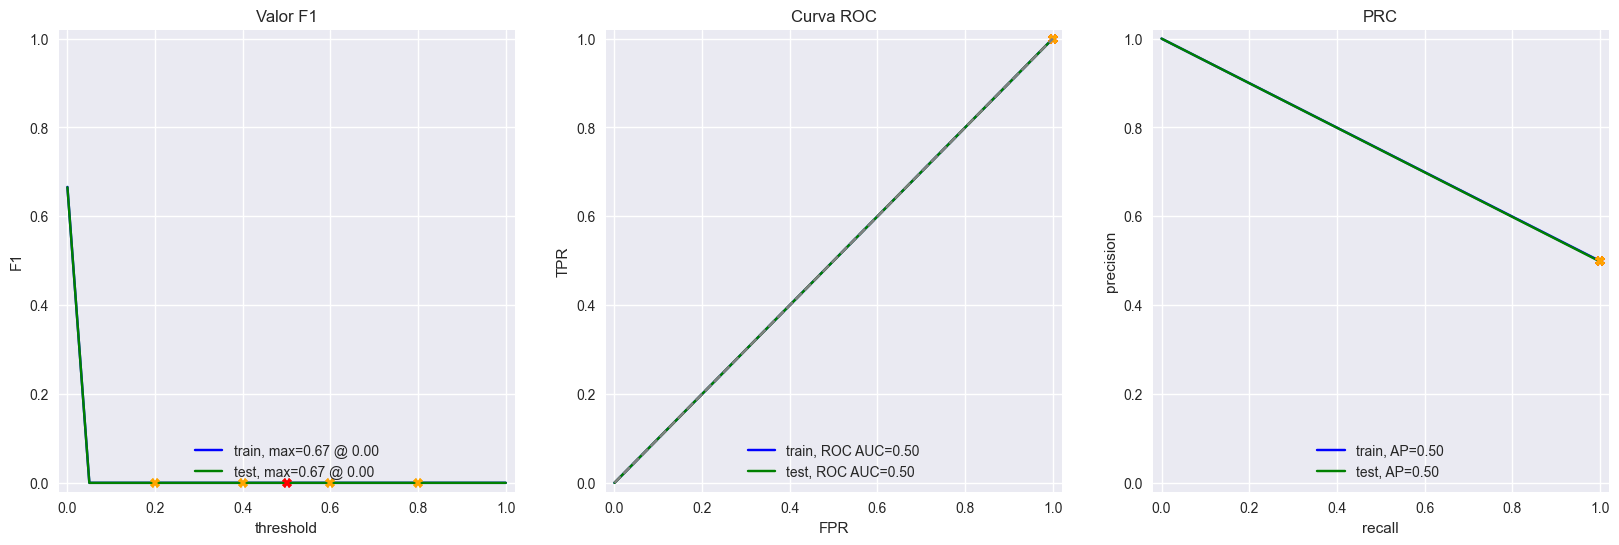

In [ ]:
#Evaluar modelo dummy
evaluate_model(dummy, X_train_vect, train_target, X_test_vect, test_target)
print("El modelo no identifica verdaderos positivos porque fue entrenado para mencionar lo más frecuente que en entrenamiento fueron los valores negativos.")
#Evidencia
print(train_target.value_counts())

### Modelo 1 - LR-Regresión logística

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=54321)
lr.fit(X_train_vect, train_target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=54321)

          train  test
Accuracy   0.91  0.61
F1         0.91  0.59
APS        0.97  0.65
ROC AUC    0.97  0.66
Discriminación de valores en set de entrenamiento F1 = 93% pero en entrenamiento solo el 59% lo cual es menor al objetivo de 85% de asertividad en distinguir positivos y negativos. 


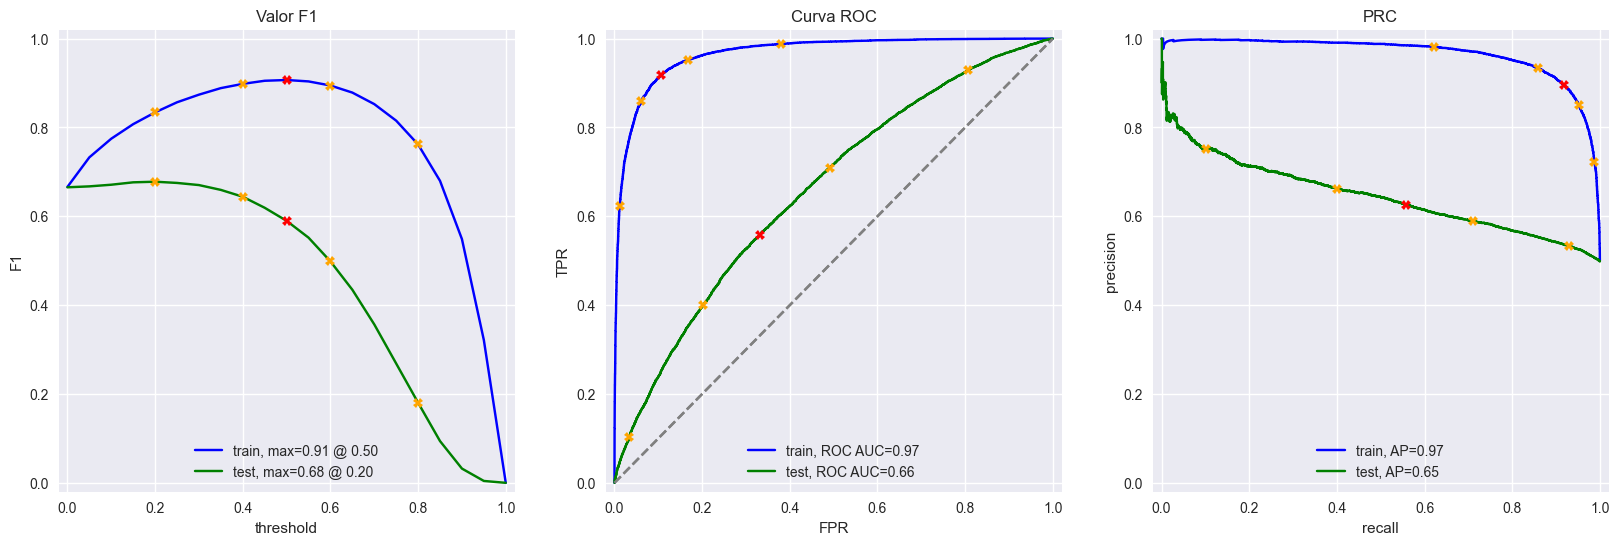

In [ ]:
#Evaluar el modelo LR
evaluate_model(lr, X_train_vect, train_target, X_test_vect, test_target)

print("Discriminación de valores en set de entrenamiento F1 = 93% pero en entrenamiento solo el 59% lo cual es menor al objetivo de 85% de asertividad en distinguir positivos y negativos. ")

### Modelo 2 - spaCy, TF-IDF y LR

In [ ]:
#Definir valores a utilizar en el modelo: vectorizar lemmatizados. (Comentado por toma de recursos y resultado no óptimo)
#x_vect_train_lemma = df_reviews_train["review_lemma"] #equivalente a features o características de entrenado
#x_vect_train_lemma = vectorizer.fit_transform(x_vect_train_lemma)
#x_vect_test_lemma = df_reviews_test["review_lemma"]
#x_vect_test_lemma = vectorizer.fit_transform(x_vect_test_lemma)

#train y test target queda igual
#Aplicar LR pero con datos lematizados 
#lr_lemma = LogisticRegression(max_iter=10000, class_weight="balanced", random_state=54321)
#lr_lemma.fit(x_vect_train_lemma, train_target)

#Evaluar el modelo 
#evaluate_model(lr_lemma, x_vect_train_lemma, train_target, x_vect_test_lemma, test_target)
print("Lema tomó recursos y no dió un patrón muy favorable. Se decidió comentar. Patrón F1 muy similar a sin lematizar. Se redujo un poco la capacidad de distinguir entre positivos y falsos F1 en prueba = 61%.")

Lema tomó recursos y no dió un patrón muy favorable. Se decidió comentar. Patrón F1 muy similar a sin lematizar. Se redujo un poco la capacidad de distinguir entre positivos y falsos F1 en prueba = 61%.


### Modelo 3 - LGBMClassifier

In [ ]:
#Muestreo para emplear menos recursos computacionales en la búsqueda de hiperparámetros
x_train_vect_sample, _, y_train_sample, _ = train_test_split(X_train_vect, train_target, train_size = 0.4, random_state = 54321)
print(x_train_vect_sample.shape)
#Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.1],
    'num_leaves': [50, 100]
}

lgbm = LGBMClassifier(random_state=42)

grid_lgbm = GridSearchCV(
    lgbm, param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=1
)
grid_lgbm.fit(x_train_vect_sample, y_train_sample)
print("Mejor F1 en validación:", grid_lgbm.best_score_)
print("Mejores parámetros:", grid_lgbm.best_params_)

y_pred_lgbm = grid_lgbm.predict(X_test_vect)
print("F1 Test:", f1_score(test_target, y_pred_lgbm))
print("Accuracy Test:", accuracy_score(test_target, y_pred_lgbm))

print("F1 es bastante bajo, lgbm con el preprocesado convencional no entiende contextos de las palabras.")




(9518, 3000)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Info] Number of positive: 4825, number of negative: 4693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176746
[LightGBM] [Info] Number of data points in the train set: 9518, number of used features: 2989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506934 -> initscore=0.027739
[LightGBM] [Info] Start training from score 0.027739
Mejor F1 en validación: 0.8441461388340146
Mejores parámetros: {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 100}


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 Test: 0.5567505192707132
Accuracy Test: 0.591934729953682
F1 es bastante bajo, lgbm con el preprocesado convencional no entiende contextos de las palabras.


[LightGBM] [Info] Number of positive: 4825, number of negative: 4693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176746
[LightGBM] [Info] Number of data points in the train set: 9518, number of used features: 2989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506934 -> initscore=0.027739
[LightGBM] [Info] Start training from score 0.027739


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.92  0.59
F1         0.92  0.56
APS        0.97  0.62
ROC AUC    0.97  0.63
El rendimiento en distinguir entre reseñas positivas y negativas de lightGBM 56% aún abajo del objetivo mayor a 85%. Se observa un menor rendimiento en valores de entrenado.


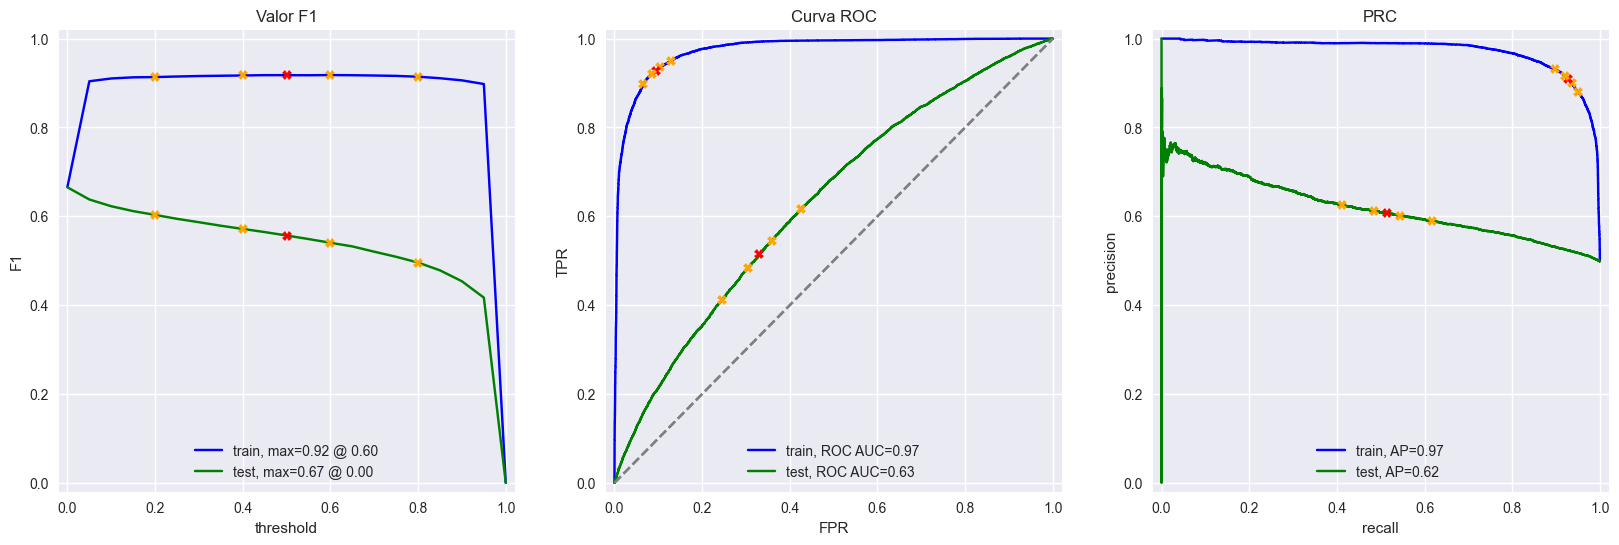

In [ ]:
#Aplicar el mejor modelo 
lgbm = LGBMClassifier(learning_rate= 0.1, n_estimators= 400, num_leaves = 100, random_state = 54321)
lgbm.fit(x_train_vect_sample, y_train_sample)

#Evaluar modelo
evaluate_model(lgbm, X_train_vect, train_target, X_test_vect, test_target)
print("El rendimiento en distinguir entre reseñas positivas y negativas de lightGBM 56% aún abajo del objetivo mayor a 85%. Se observa un menor rendimiento en valores de entrenado.")

Modelo 4-Procesamiento contextual con embeddings + LR o lgbm

          train  test
Accuracy   0.89  0.88
F1         0.89  0.88
APS        0.96  0.95
ROC AUC    0.96  0.95
Usando embeddings el modelo mejoró aún con el uso de una cantidad mínima de datos. Se usará lgbm con embeddings. F1 = 80% < 85%.


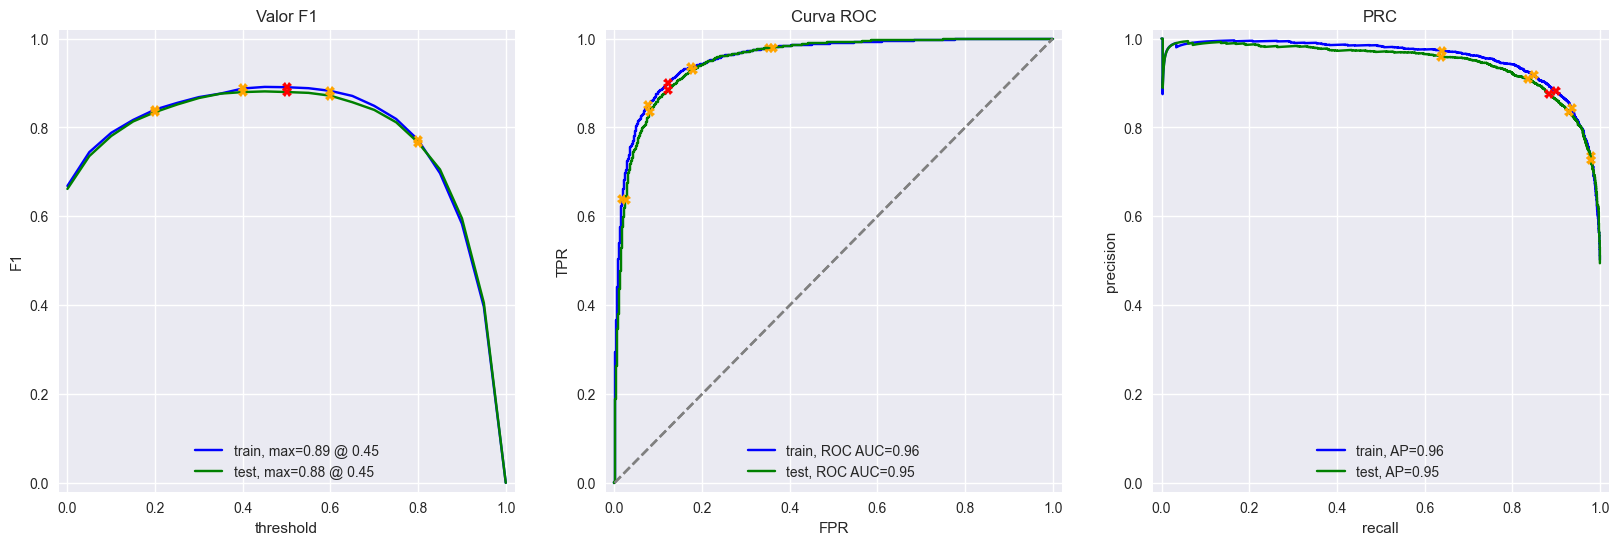

In [ ]:
#Modelo LR. 
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=54321)
clf.fit(train_embeddings, train_embed_target_sample)

#Evaluar el modelo 
evaluate_model(clf, train_embeddings, train_embed_target_sample, test_embeddings, test_embed_target_sample) #Nota: los objetivos o target no son embed se usó ese nombre para generar similitud de variables.
print("Usando embeddings el modelo mejoró aún con el uso de una cantidad mínima de datos. Se usará lgbm con embeddings. F1 = 80% < 85%.")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Info] Number of positive: 2986, number of negative: 2963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5949, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501933 -> initscore=0.007732
[LightGBM] [Info] Start training from score 0.007732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


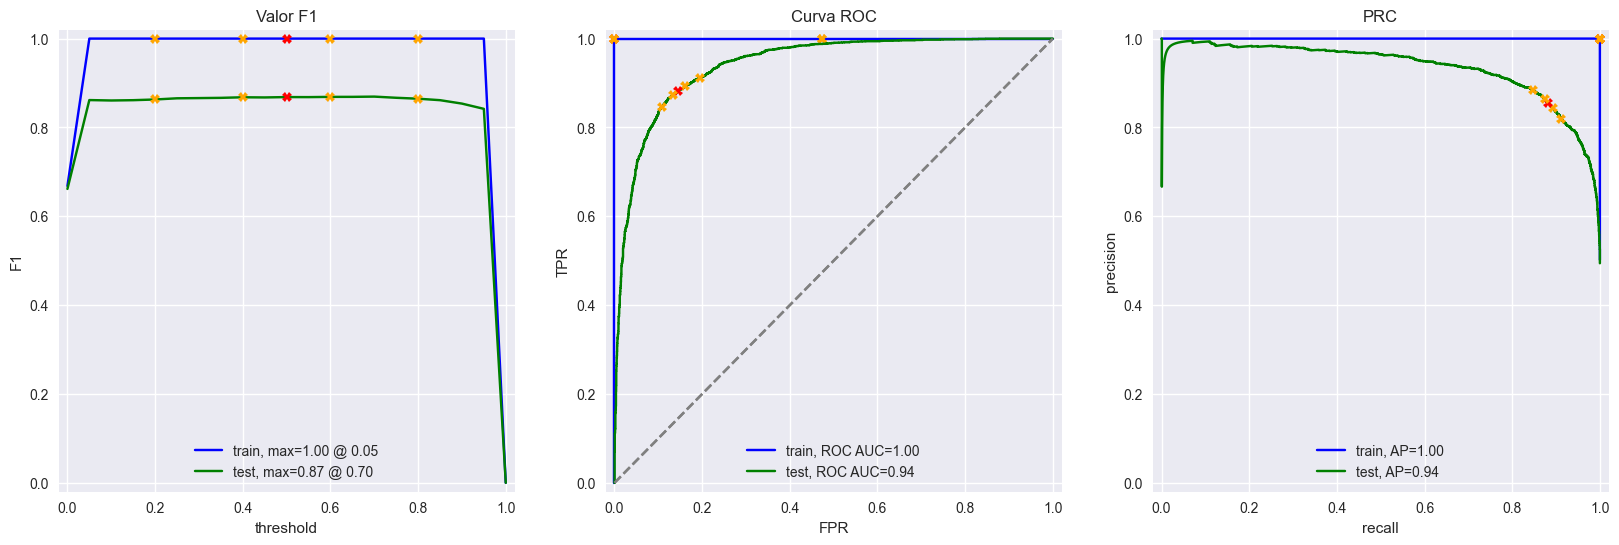

In [ ]:
#Modelo lgbm
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.1],
    'num_leaves': [50, 100]
}

lgbm = LGBMClassifier(random_state=54321)

grid_lgbm_embed = GridSearchCV(
    lgbm, param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=1
)

grid_lgbm_embed.fit(train_embeddings, train_embed_target_sample)
#Mejor modelo 
grid_lgbm_embed_hiperparameter_tunned = grid_lgbm_embed.best_estimator_
#Evaluate model 
evaluate_model(grid_lgbm_embed_hiperparameter_tunned, train_embeddings, train_embed_target_sample, test_embeddings, test_embed_target_sample)

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(clean_text)

#Embedding
my_reviews = embedding_model.encode(my_reviews['review_norm'].tolist(), batch_size=32, show_progress_bar=True)

np.savez_compressed("my_reviews.npz", valid = my_reviews)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Modelo 1

In [ ]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = lr.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print("Los números son probabilidades de que la reseña sea positiva.")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3 -LR con embeddings

In [ ]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = clf.predict_proba(texts_embeddings)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = best_lgbm.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

In [ ]:
Se revisaron multiples modelos. 

Control, regresión lineal y ML lgbm con vectores 

y regresión lineal y lgbm con consideración semántica o embeddings. 

Se llegó a un 88% de discriminación entre sentimientos positivos y negativos en reseñas por modelo de regresión lineal y 87% por lgbm. 

Lgbm al probarlo con las reseñas de validación fue mucho más preciso con lo esperado (sección 8; 8.3 vs 8.4.).

Se cumplió con el umbral de aceptación F1 = 87% y 88% > 85%. 

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones